In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./data/train.csv')

#### First, get list of all records with missing values. See if we can drop them all
#### Recognized there are no records without missing information
#### Next, if we can drop them all, we can run random forest to see which features are most important.
#### Finally, we can impute in order of importance; for most important features, we will impute them first, then work downward.

In [3]:
df.shape

(30471, 292)

## A count of all missing values

In [4]:
nullList = df.isnull().sum()
na_list=nullList[nullList>0].sort_values(ascending=False)

In [5]:
print('Count of columns with missing values: {}\nCount of columns without missing values: {}'.format(nullList[nullList>0].sort_values(ascending=False).count(), nullList[nullList==0].sort_values(ascending=False).count()))

Count of columns with missing values: 51
Count of columns without missing values: 241


In [6]:
print('Percent of dataset records with null values: {}%'.format(round(nullList[nullList>0].max()/df.shape[0]*100, 2)))

Percent of dataset records with null values: 47.39%


### A dataframe of missing values and their data types for selecting imputation algorithm

### We're assuming not every neighborhood in Moscow has a hospital, just as not every neighborhood in Dallas has a hospital.

In [7]:
df_missing = pd.DataFrame(list(zip(na_list.index, na_list.values)), columns=['feature','na_count'])
df_dtypes = pd.DataFrame(list(zip(df.dtypes.index, df.dtypes)), columns=['feature','type'])
df_missing.merge(df_dtypes, how='inner', on='feature')

,feature,na_count,type
0,hospital_beds_raion,14441,float64
1,build_year,13605,float64
2,state,13559,float64
3,cafe_sum_500_min_price_avg,13281,float64
4,cafe_sum_500_max_price_avg,13281,float64
5,cafe_avg_price_500,13281,float64
6,max_floor,9572,float64
7,material,9572,float64
8,num_room,9572,float64
9,kitch_sq,9572,float64


In [8]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [9]:
df_cats = df.select_dtypes(include=['O'])

In [10]:
df_cats2 = df_cats.drop('timestamp',axis=1)

In [11]:
print('Categorical cardinality:\n\nFeature product_type:\n{}\n\nFeature ecology:\n{}\n\nFeature sub_area:\n{}'.format(df_cats['product_type'].unique(), df_cats['ecology'].unique(), df_cats['sub_area'].unique()))

Categorical cardinality:

Feature product_type:
['Investment' 'OwnerOccupier']

Feature ecology:
['good' 'excellent' 'poor' 'satisfactory' 'no data']

Feature sub_area:
['Bibirevo' 'Nagatinskij Zaton' "Tekstil'shhiki" 'Mitino' 'Basmannoe'
 'Nizhegorodskoe' "Sokol'niki" 'Koptevo' 'Kuncevo' 'Kosino-Uhtomskoe'
 'Zapadnoe Degunino' 'Presnenskoe' 'Lefortovo' "Mar'ino" "Kuz'minki"
 'Nagornoe' "Gol'janovo" 'Vnukovo' 'Juzhnoe Tushino' 'Severnoe Tushino'
 "Chertanovo Central'noe" 'Fili Davydkovo' 'Otradnoe' 'Novo-Peredelkino'
 'Bogorodskoe' 'Jaroslavskoe' 'Strogino' 'Hovrino' "Moskvorech'e-Saburovo"
 'Staroe Krjukovo' 'Ljublino' 'Caricyno' 'Veshnjaki' 'Danilovskoe'
 'Preobrazhenskoe' "Kon'kovo" 'Brateevo' 'Vostochnoe Izmajlovo'
 'Vyhino-Zhulebino' 'Donskoe' 'Novogireevo' 'Juzhnoe Butovo' 'Sokol'
 'Kurkino' 'Izmajlovo' 'Severnoe Medvedkovo' 'Rostokino'
 'Orehovo-Borisovo Severnoe' 'Ochakovo-Matveevskoe' 'Taganskoe'
 'Dmitrovskoe' 'Orehovo-Borisovo Juzhnoe' 'Teplyj Stan' 'Babushkinskoe'
 'Pokrovs

In [12]:
df_cats2['sub_area'].isnull().sum()

0

In [13]:
df_cats2.drop('sub_area',axis=1)

,product_type,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,Investment,no,no,no,no,no,no,no,no,no,no,no,no,good
1,Investment,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
2,Investment,no,no,no,no,yes,no,no,no,no,no,no,no,poor
3,Investment,no,no,no,no,no,no,no,no,no,no,no,no,good
4,Investment,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,Investment,no,no,yes,no,yes,no,no,no,no,no,no,no,good
30467,Investment,yes,no,no,no,yes,yes,no,no,yes,no,no,no,poor
30468,OwnerOccupier,no,no,no,no,no,no,no,no,no,no,no,no,no data
30469,Investment,no,no,no,no,yes,no,no,no,no,no,no,no,satisfactory


In [14]:
df_cats2['sub_area']

0                    Bibirevo
1           Nagatinskij Zaton
2              Tekstil'shhiki
3                      Mitino
4                   Basmannoe
                 ...         
30466                Otradnoe
30467                Tverskoe
30468    Poselenie Vnukovskoe
30469            Obruchevskoe
30470             Novogireevo
Name: sub_area, Length: 30471, dtype: object

# One-hot and label encode

In [15]:
sub_area = df_cats2['sub_area'].astype('category')
one_hots = df_cats2.drop('sub_area',axis=1)
sub_area_final = sub_area.cat.codes
one_hots_final = pd.get_dummies(one_hots)

(array([2165., 2494., 2766., 2539., 4528., 2817., 2297., 5204., 2768.,
        2893.]),
 array([  0. ,  14.5,  29. ,  43.5,  58. ,  72.5,  87. , 101.5, 116. ,
        130.5, 145. ]),
 <BarContainer object of 10 artists>)

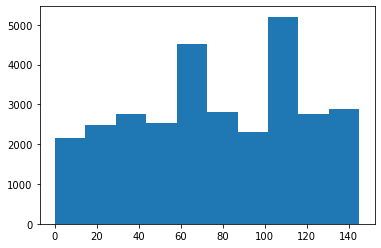

In [16]:
import matplotlib.pyplot as plt
plt.hist(sub_area.cat.codes)

In [17]:
sub_area.isna().sum()

0

In [18]:
encodes = pd.concat([sub_area_final,one_hots_final], axis=1).astype('int64')

# Get a list of the non-null values and run a model to predict price_doc
## Concatenate with encoded variables

In [19]:
print('time range: [{}, {}]'.format(df['timestamp'].min(),df['timestamp'].max()))

time range: [2011-08-20, 2015-06-30]


In [20]:
nullList = df.isnull().sum()
non_naList=nullList[nullList==0].sort_values(ascending=False)
non_null_features = list(non_naList.index)

In [21]:
df[non_null_features].dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [22]:
no_null_df = df[non_null_features].drop(['id','timestamp'], axis=1).select_dtypes(include=['int64','float64'])

In [23]:
df_no_null = pd.concat([no_null_df, encodes], axis=1)

In [24]:
df_no_null

,price_doc,catering_km,zd_vokzaly_avto_km,railroad_km,ID_big_road2,big_road2_km,ID_big_road1,big_road1_km,kremlin_km,bulvar_ring_km,...,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,5850000,0.516838,14.231961,1.305159,5,3.830951,1,1.422391,15.156211,13.675657,...,0,1,0,1,0,0,1,0,0,0
1,6000000,0.230287,9.242586,0.694536,4,3.103996,2,2.887377,8.698054,8.132640,...,0,1,0,1,0,1,0,0,0,0
2,5700000,0.190462,9.540544,0.700691,4,2.927487,3,0.647250,9.067885,8.054252,...,0,1,0,1,0,0,0,0,1,0
3,13100000,0.465820,17.478380,1.999265,17,2.780449,1,2.677824,19.487005,18.309433,...,0,1,0,1,0,0,1,0,0,0
4,16331452,0.026102,1.595898,0.084113,10,3.133531,4,1.721834,2.578671,0.787593,...,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,7400000,0.055377,11.396447,1.137603,1,3.762408,5,3.096057,12.599292,11.118577,...,0,1,0,1,0,0,1,0,0,0
30467,25000000,0.007476,1.010437,0.377368,34,1.245704,4,1.238732,3.269284,1.874868,...,0,1,0,1,0,0,0,0,1,0
30468,6970959,0.066503,25.699461,1.727223,27,3.688405,13,2.808077,21.905792,21.038561,...,0,1,0,1,0,0,0,1,0,0
30469,13500000,0.134566,15.303338,4.898047,51,2.174001,16,0.960608,13.622569,12.872535,...,0,1,0,1,0,0,0,0,0,1


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

## Correlation matrix including encoded categorical data

In [26]:
# Compute the correlation matrix
corr = df_no_null.corr()

## Correlation matrix excluding categorical data

In [27]:
# Compute the correlation matrix
corr = no_null_df.corr()

# There is no strong correlation in the dataset when there are only columns that do not contain NA

In [28]:
corr

,price_doc,catering_km,zd_vokzaly_avto_km,railroad_km,ID_big_road2,big_road2_km,ID_big_road1,big_road1_km,kremlin_km,bulvar_ring_km,...,green_part_1500,market_count_1000,sport_count_1000,leisure_count_1000,mosque_count_1000,church_count_1000,big_church_count_1000,cafe_count_1000_price_high,cafe_count_1000_price_4000,cafe_count_1000_price_2500
price_doc,1.000000,-0.210793,-0.284069,-0.094227,-0.081559,-0.160778,-0.067234,-0.103737,-0.279249,-0.279158,...,-0.079636,0.065118,0.197994,0.099571,0.089308,0.053886,0.086258,0.169175,0.036268,0.090532
catering_km,-0.210793,1.000000,0.619926,0.253281,0.224361,0.245286,0.217302,0.260477,0.564106,0.563799,...,0.217940,-0.231649,-0.397095,-0.156566,-0.076041,-0.152745,-0.187698,-0.121572,-0.131081,-0.166711
zd_vokzaly_avto_km,-0.284069,0.619926,1.000000,0.441031,0.316575,0.565361,0.303100,0.265185,0.965716,0.970654,...,0.382032,-0.256002,-0.570010,-0.276806,-0.049883,-0.282248,-0.335648,-0.235553,-0.241601,-0.290892
railroad_km,-0.094227,0.253281,0.441031,1.000000,0.057988,0.452117,0.510551,0.003233,0.382257,0.395364,...,0.317969,-0.101265,-0.188953,-0.014655,-0.006021,0.024143,-0.033003,-0.020876,0.022922,0.009632
ID_big_road2,-0.081559,0.224361,0.316575,0.057988,1.000000,0.145405,-0.178465,0.130972,0.328587,0.332546,...,0.119148,-0.062326,-0.065434,0.012908,0.023073,0.059926,0.031303,-0.002021,0.068199,0.057916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
church_count_1000,0.053886,-0.152745,-0.282248,0.024143,0.059926,0.029901,-0.110303,0.200375,-0.371454,-0.347974,...,-0.178918,0.145025,0.636725,0.882447,0.038423,1.000000,0.954694,0.514722,0.936893,0.944945
big_church_count_1000,0.086258,-0.187698,-0.335648,-0.033003,0.031303,-0.039448,-0.144084,0.180980,-0.411367,-0.390458,...,-0.203325,0.140889,0.662959,0.868943,0.029719,0.954694,1.000000,0.546070,0.905742,0.919720
cafe_count_1000_price_high,0.169175,-0.121572,-0.235553,-0.020876,-0.002021,-0.053799,-0.032215,0.062495,-0.284384,-0.274015,...,-0.151574,0.054525,0.462501,0.605466,0.062536,0.514722,0.546070,1.000000,0.594749,0.632514
cafe_count_1000_price_4000,0.036268,-0.131081,-0.241601,0.022922,0.068199,0.031269,-0.093350,0.223808,-0.329147,-0.305069,...,-0.160743,0.127106,0.613423,0.900649,0.003209,0.936893,0.905742,0.594749,1.000000,0.975458


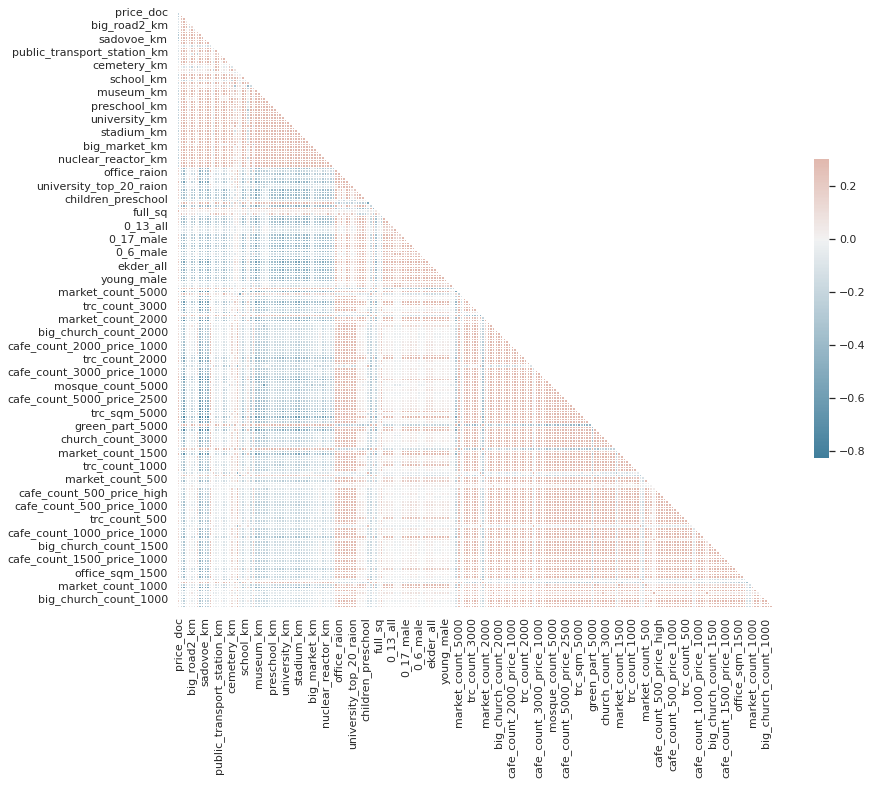

In [29]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});

# Running a linear regression on price_doc to assess model performance without variables having missing values. This will be compared again after imputing

In [31]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = df_no_null['price_doc']
X = df_no_null.drop(['price_doc'], axis=1)
normalized_X = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
regress = linear_model.LinearRegression()
regress.fit(X_train, y_train)
y_preds = regress.predict(X_test)
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_preds)))

Mean Squared Error: 13723467429839.291


### Using Ordinary Least Squares to check out serial correlation and feature importance relative to price_doc (y)

In [ ]:
import statsmodels.api as sm
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
#est2.summary(alpha=0.05)

### Durbin-Watson test statistic using lag-1 horizons indicate - with a value almost equal to 2 - that there is a very minimal risk of serial correlation. Therefore, a time series model is not required.

In [34]:
import statsmodels
resids = y_test-y_preds
print('Durbin-Watson test for serial correlation (lag-1 auto-correlation): {}'.format(round(statsmodels.stats.stattools.durbin_watson(resids, axis=0),3)))

Durbin-Watson test for serial correlation (lag-1 auto-correlation): 1.983


### A low adjusted r-squared indicates there is too much multi-collinearity in the data and the right features may not be included. Therefore, imputation is necessary.

In [35]:
print('Adjusted R-Square: {}'.format(round(est2.rsquared_adj, 3)))

Adjusted R-Square: 0.352


### The very low value of the smallest eigenvalue also indicates strong multi-collinearity by suggesting the matrix is close to singular

In [36]:
est2.eigenvals.min()

1.1193571907349716e-13

In [37]:
print('Percent of features that are statistically significant: {}%'.format(round(est2.pvalues[est2.pvalues < 0.05].count() / est2.pvalues.count()*100, 2)))

Percent of features that are statistically significant: 45.31%


In [38]:
est2.pvalues[est2.pvalues < 0.05].sort_values()

full_sq                       0.000000e+00
product_type_OwnerOccupier    6.006795e-47
railroad_1line_no             2.355999e-25
incineration_raion_yes        1.250483e-24
ecology_good                  4.090632e-18
                                  ...     
big_road1_km                  3.819453e-02
work_female                   4.489686e-02
work_male                     4.491999e-02
church_count_1000             4.527826e-02
mosque_count_2000             4.840062e-02
Length: 116, dtype: float64

### In the above output, the test for smallest eigenvalue indicates strong multi-collinearity. This is important because it likely means there is enough data to make accurate assessments about the missing information.

In [39]:
df_numeric = df.select_dtypes(include=['int64','float64'])

In [40]:
df_numeric

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,3.0,...,15,5,0,15,26,1,2,84,6,7400000
30467,30470,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,3.0,...,313,128,24,98,182,1,82,171,15,25000000
30468,30471,45,NaN,10.0,20.0,1.0,NaN,1.0,1.0,1.0,...,1,1,0,2,12,0,1,11,1,6970959
30469,30472,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,2.0,...,22,1,1,6,31,1,4,65,7,13500000


# After running a linear regression on the data without imputing any values and only using columns that do not have missing information, we have an error of

In [41]:
df.loc[df['hospital_beds_raion'],'hospital_beds_raion'].count()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Float64Index([nan, nan, nan, nan, nan,\n              ...\n              nan, nan, nan, nan, nan],\n             dtype='float64', length=14441). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
df.shape[0]

In [ ]:
print('Percent of hospital_beds_raion with missing values: {}%'.format(round(100*df['hospital_beds_raion'].isna().sum()/df.shape[0],2)))

In [ ]:
df.loc[df['hospital_beds_raion'].isna(),'hospital_beds_raion'].count()

In [ ]:
neighborhoods = pd.concat([df['sub_area'],df['hospital_beds_raion']], axis=1)
s = neighborhoods.groupby(neighborhoods['sub_area']).sum()

#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
s.sort_values(by='sub_area')

Because missing values for hospital_beds_raion are missing not at random - meaning neighborhoods that have values have values across all records whereas neighborhoods that do not have values have no values across all records - we will impute missing values for hospital_beds_raion with value zero.

In [ ]:
df.loc[df['hospital_beds_raion'].isna(),'hospital_beds_raion'] = 0

In [ ]:
df['hospital_beds_raion'].isna().sum()

In [ ]:
#df[.loc[df['hospital_beds_raion'].isna(),'hospital_beds_raion']] = df.loc[df['life_sq'].isna(),'full_sq']